## Logistic Regression
This notebook runs the drug repurposing project's first model, logistic regression. Run all 50 assays, first part would be creating the predictive logistic regression for each assay, and save feature coefficients. We'll use the statistic logistic regression model to look at specific uncommon features' p-value/std error

### Predictive models

In [ ]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import Lasso

import pymc as pm
import arviz as az

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

# Set working directory
path = '/content/drive/My Drive/Tox21_data/'

Mounted at /content/drive


In [ ]:
xls = pd.ExcelFile(path + 'Tox21/assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


22

In [ ]:
xls2 = pd.ExcelFile(path + 'Tox21/assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

### Run all 50 assays

In [ ]:
label_encoder = preprocessing.LabelEncoder()
# saving list for performance metrics
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs_w = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []

# Others
lambda_sig_w = []
coefs_w = []
X_tests = []
y_tests = []

# feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
#                   'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
#                   'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
#                   'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
#                   'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
#                   'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
#                   'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
#                   'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
#                   'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']

feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']


for j in range(5):
  for i in range(len(df)):
      scaler = StandardScaler()

      one_assay = df[i]
      one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates(subset = 'SMILES')
      y = label_encoder.fit_transform(one_assay.iloc[:,0])
      X = one_assay[one_assay.columns.intersection(feature_top_40)]

      X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = 42)
      X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25,
                                                            shuffle=True, random_state = j)# 5 CV on training

      near_miss = RandomUnderSampler(random_state = j)
      X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)# undersampling
      # print(Counter(y_train_resampled))
      # print(Counter(y_train))
      X_train = scaler.fit_transform(X_train_resampled)
      X_valid = scaler.transform(X_valid)
      X_test = scaler.transform(X_test)

      logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,
                                                  max_iter=10000,class_weight=None).fit(X_train, y_train_resampled)
      # logistic_cv_balanced = LogisticRegressionCV(penalty='l1',solver = 'saga', class_weight=None).fit(X_train, y_train_resampled)
      ## Others
      coef_w = logistic_cv_balanced.coef_[0]
      coefs_w.append(coef_w)

      X_tests.append(X_test)
      y_tests.append(y_test)

      ## model predictions
      y_train_pred = logistic_cv_balanced.predict(X_train)
      y_valid_pred = logistic_cv_balanced.predict(X_valid)
      y_test_pred = logistic_cv_balanced.predict(X_test)

      y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
      y_valid_pred_prob = logistic_cv_balanced.predict_proba(X_valid)[:,1]
      y_test_pred_prob = logistic_cv_balanced.predict_proba(X_test)[:,1]

      ## model performance metrics
      bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)
      bal_acc_v = balanced_accuracy_score(y_valid, y_valid_pred)
      bal_acc_w = balanced_accuracy_score(y_test,y_test_pred)

      auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)
      auc_score_v = metrics.roc_auc_score(y_valid, y_valid_pred_prob)
      auc_score_w = metrics.roc_auc_score(y_test, y_test_pred_prob)

      recall_t = metrics.recall_score(y_train_resampled,y_train_pred)
      recall_v = metrics.recall_score(y_valid, y_valid_pred)
      recall_score = metrics.recall_score(y_test, y_test_pred)

      f1_t = metrics.f1_score(y_train_resampled,y_train_pred)
      f1_v = metrics.f1_score(y_valid, y_valid_pred)
      f1_score = metrics.f1_score(y_test, y_test_pred)

      precision_t = metrics.precision_score(y_train_resampled,y_train_pred)
      precision_v = metrics.precision_score(y_valid, y_valid_pred)
      precision_score = metrics.precision_score(y_test, y_test_pred)

      ## save perfomance
      ## Training
      bal_accs_t.append(bal_acc_t)
      auc_scores_t.append(auc_score_t)
      precisions_t.append(precision_t)
      recalls_t.append(recall_t)
      f1s_t.append(f1_t)

      ## Validation
      bal_accs_v.append(bal_acc_v)
      auc_scores_v.append(auc_score_v)
      precisions_v.append(precision_v)
      recalls_v.append(recall_v)
      f1s_v.append(f1_v)

      ## Testing
      bal_accs_w.append(bal_acc_w)
      auc_scores_w.append(auc_score_w)
      precision_scores.append(precision_score)
      recall_scores.append(recall_score)
      f1_scores.append(f1_score)

  print(len(auc_scores_t))
  print(j)


50
0
100
1
150
2
200
3
250
4


In [ ]:
#undersampling 80/20 split testing
print('BACC', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.7440424626088354
0.028177139616419256
auc 0.8140147741824758
0.028450120085984743
f1 0.3468376104998945
0.11548450468305944
recall 0.7323557919777932
0.05245771125360614
precision 0.23802481586913463
0.11225359453112685


In [ ]:
#undersampling 80/20 split testing
print('BACC', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.5470726950501431
0.039923793610313424
auc 0.6139181647188195
0.0947700740602875
f1 0.16670230304647465
0.06913177359216384
recall 0.6516649298232292
0.33240541232201687
precision 0.12136977582918368
0.07953377313187257


In [ ]:
# undersampling 80/20 split training
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1s_t))
print(np.std(f1s_t))

print('recall', np.mean(recalls_t))
print(np.std(recalls_t))

print('precision', np.mean(precisions_t))
print(np.std(precisions_t))

BACC 0.7783394082172237
0.028795037929539795
auc 0.8556577261617374
0.029542562345389795
f1 0.7754165363664263
0.029942073773482476
recall 0.7659854490000356
0.035378166301479066
precision 0.7855080725109319
0.02884910804001548


In [ ]:
# undersampling 80/20 split validation
print('BACC', np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print('auc', np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print('f1', np.mean(f1s_v))
print(np.std(f1s_v))

print('recall', np.mean(recalls_v))
print(np.std(recalls_v))

print('precision', np.mean(precisions_v))
print(np.std(precisions_v))

BACC 0.7428890275157173
0.023581904854125854
auc 0.816695392967767
0.02455560749510574
f1 0.34773397202934164
0.11729752507415184
recall 0.7285044777669054
0.04719324474641213
precision 0.23936480052027673
0.11259525101969338


In [ ]:
X_test_scale = scaler.transform(X_test)
X_test_scale

array([[-0.90551392,  1.89311144, -1.32486968, ..., -0.67062556,
        -0.54218856, -0.29862162],
       [ 2.59499275, -0.28233442,  2.00539873, ...,  0.19682683,
         2.06598646, -0.29862162],
       [ 3.32563775, -0.72025729,  2.77412669, ...,  1.93173162,
        -0.54218856, -0.29862162],
       ...,
       [ 0.20663974, -0.16675576, -0.03802287, ...,  1.06427923,
         1.19659479, -0.29862162],
       [ 0.0439307 , -0.1378747 , -0.05606554, ...,  0.19682683,
         0.32720312, -0.29862162],
       [-0.03985043,  0.14860145, -0.23503383, ...,  0.19682683,
        -0.54218856, -0.29862162]])

In [ ]:
print(scaler.var_)

[7.67105031e-02 2.70456595e-02 6.92982577e-02 1.99066137e-02
 1.95000278e-01 3.25594146e-01 3.71963815e-02 8.43635311e-02
 1.53609497e+00 1.41816759e+01 4.10150497e+00 1.70655942e+00
 8.34054934e+01 1.34258708e+02 2.80032010e+02 2.93714730e+02
 4.97170092e+01 1.09564974e+03 1.14418840e+02 5.58239537e+01
 1.93364414e+02 6.61809818e+02 2.75888862e+03 2.99582928e+02
 1.11423358e+02 3.34692346e+01 2.44370811e+02 1.30763094e+02
 5.38472925e+01 3.35051212e+01 7.49490968e+00 1.02813488e-01
 9.66423511e-01 7.65215730e+00 1.50895553e+01 4.82866774e-01
 9.89123051e-01 1.32895019e+00 1.32302805e+00 3.08121160e-01]


In [ ]:
y_test_pred_scale = logistic_cv_balanced.predict(X_test_scale)
bal_acc_scale = balanced_accuracy_score(y_test,y_test_pred_scale)

In [ ]:
bal_acc_scale

0.7381000418744528

In [ ]:
# old 40 features
print('BACC', np.mean(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

BACC 0.7461653972131066
0.02271895181561692
auc 0.8276494906521482
0.023577144937877742


In [ ]:
pd.DataFrame(bal_accs_w).to_csv(path + 'lg_bal_acc_80_20.csv', index=False)
pd.DataFrame(auc_scores_w).to_csv(path + 'lg_auc_80_20.csv', index=False)
pd.DataFrame(bal_accs_t).to_csv(path + 'lg_bal_acc_t_80_20.csv', index=False)
pd.DataFrame(auc_scores_t).to_csv(path + 'lg_auc_t_80_20.csv', index=False)

In [ ]:
print(np.mean(bal_accs))
print(np.std(bal_accs))

print('auc', np.mean(auc_scores))
print(np.std(auc_scores))

0.5608002105548504
0.05030848905258878
auc 0.8107918804293428
0.03281755003567954


In [ ]:
print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

f1 0.3572611837466816
0.10759088408427916
recall 0.7221052800018343
0.044949881885205545
precision 0.24658441657723665
0.10528400905832704


### save all coefficients and change columns and rows name

In [ ]:
# coefs_df = pd.DataFrame(coefs).T
coefs_w_df = pd.DataFrame(coefs_w).T

In [ ]:
coefs_w_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.074849,0.078589,13.402973,-0.131102,-0.156741,16.329869,0.104934,-0.064955,2.198375,0.419546,...,0.115598,6.092481,2.038242,1.612144,0.103462,0.207092,1.132057,0.079502,7.604398,15.553206
1,0.011628,-0.490328,-7.686043,-0.138753,0.073509,-11.399799,-0.039089,-0.121341,-0.922460,-0.020673,...,-0.781412,-3.553176,-1.089355,-1.087807,-0.098180,-0.108381,-0.674400,0.008863,-5.533077,-9.432902
2,0.100057,-0.355579,-12.546116,0.006445,-0.035834,-15.784983,0.230001,-0.043912,-1.586113,-0.398239,...,-0.158137,-5.501997,-1.629834,-1.368715,0.107750,-0.130251,-0.938523,0.102278,-7.169378,-14.845753
3,-0.051989,-0.237929,-6.992975,-0.144127,0.021512,-9.566511,-0.214765,-0.122154,-1.377828,-0.302631,...,-0.636361,-3.327864,-1.119022,-0.859967,-0.108273,-0.274164,-0.712625,-0.152729,-5.065423,-7.972905
4,-0.124236,-1.396041,-0.049066,-0.026520,-0.946585,-0.005585,-0.275733,-0.413679,0.407486,0.242543,...,-3.155957,0.122812,-0.000170,-0.059805,-0.514554,-0.459954,-0.516841,-0.127353,-0.244840,-0.091444
5,0.004773,1.111034,-0.345018,-0.118788,0.753980,-0.150805,-0.070285,0.427615,-0.781584,-0.489184,...,2.300544,-0.268801,-0.173550,0.006620,0.429084,0.598996,0.521632,0.104117,-0.550014,-0.075775
6,-0.119567,0.232676,-0.011975,-0.000268,0.677119,0.127619,0.044403,0.198174,0.760791,0.509470,...,1.931052,0.297641,0.358944,0.380307,0.339771,-0.005815,0.198090,-0.073084,1.428862,0.228676
7,-0.237064,-0.858460,-0.342602,-0.293249,-0.869331,-0.401116,-0.153509,-0.504023,-0.969729,-0.879185,...,-2.039067,-0.540279,-0.499511,-0.534974,-0.503717,-0.426881,-0.403729,-0.268617,-1.874091,-0.414619
8,-0.065019,-0.127484,-0.291751,-0.213791,-0.279597,-0.083398,-0.052473,-0.172422,-0.314692,-0.269721,...,-0.347046,-0.139022,-0.057158,-0.079454,0.256232,-0.101251,-0.168272,-0.094400,-0.526775,-0.307750
9,0.265209,0.738055,0.583733,0.372792,0.663573,0.580824,0.322224,0.628283,1.239993,0.720505,...,2.699128,0.766914,0.267199,0.900516,0.540353,0.301824,0.450004,0.285306,1.177300,0.758826


In [ ]:
# fea_name = one_assay.iloc[:,2:].columns
fea_name = feature_top_40
len(fea_name)

40

In [ ]:
assay_name = []
for i in range(len(df)):
    one_assay = df[i]
    y = one_assay.columns[1]
    assay_name.append(y)
len(assay_name)
assay_name

['tox21-ahr-p1',
 'tox21-ap1-agonist-p1',
 'tox21-ar-bla-antagonist-p1',
 'tox21-ar-mda-kb2-luc-agonist-p3',
 'tox21-ar-mda-kb2-luc-antagonist-p1',
 'tox21-ar-mda-kb2-luc-antagonist-p2',
 'tox21-are-bla-p1',
 'tox21-aromatase-p1',
 'tox21-car-agonist-p1',
 'tox21-car-antagonist-p1',
 'tox21-elg1-luc-agonist-p1',
 'tox21-er-bla-antagonist-p1',
 'tox21-er-luc-bg1-4e2-agonist-p4',
 'tox21-er-luc-bg1-4e2-antagonist-p1',
 'tox21-er-luc-bg1-4e2-antagonist-p2',
 'tox21-erb-bla-antagonist-p1',
 'tox21-erb-bla-p1',
 'tox21-err-p1',
 'tox21-esre-bla-p1',
 'tox21-fxr-bla-agonist-p2',
 'tox21-fxr-bla-antagonist-p1',
 'tox21-gh3-tre-antagonist-p1',
 'tox21-gr-hela-bla-antagonist-p1',
 'tox21-h2ax-cho-p2',
 'tox21-hdac-p1',
 'tox21-hre-bla-agonist-p1',
 'tox21-hse-bla-p1',
 'tox21-mitotox-p1',
 'tox21-nfkb-bla-agonist-p1',
 'tox21-p53-bla-p1',
 'tox21-pgc-err-p1',
 'tox21-ppard-bla-agonist-p1',
 'tox21-ppard-bla-antagonist-p1',
 'tox21-pparg-bla-antagonist-p1',
 'tox21-pr-bla-agonist-p1',
 'tox21-pr

In [ ]:
# coefs_df.columns = assay_name
# coefs_df

In [ ]:
# coefs_df.set_axis(fea_name, axis=0)
# coefs_df.columns

In [ ]:
# coefs_w_df.columns = assay_name
coefs_w_df.set_axis(fea_name, axis=0)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
fr_C_O,0.074849,0.078589,13.402973,-0.131102,-0.156741,16.329869,0.104934,-0.064955,2.198375,0.419546,...,0.115598,6.092481,2.038242,1.612144,0.103462,0.207092,1.132057,0.079502,7.604398,15.553206
TPSA,0.011628,-0.490328,-7.686043,-0.138753,0.073509,-11.399799,-0.039089,-0.121341,-0.922460,-0.020673,...,-0.781412,-3.553176,-1.089355,-1.087807,-0.098180,-0.108381,-0.674400,0.008863,-5.533077,-9.432902
SMR_VSA1,0.100057,-0.355579,-12.546116,0.006445,-0.035834,-15.784983,0.230001,-0.043912,-1.586113,-0.398239,...,-0.158137,-5.501997,-1.629834,-1.368715,0.107750,-0.130251,-0.938523,0.102278,-7.169378,-14.845753
NumHAcceptors,-0.051989,-0.237929,-6.992975,-0.144127,0.021512,-9.566511,-0.214765,-0.122154,-1.377828,-0.302631,...,-0.636361,-3.327864,-1.119022,-0.859967,-0.108273,-0.274164,-0.712625,-0.152729,-5.065423,-7.972905
NumAromaticCarbocycles,-0.124236,-1.396041,-0.049066,-0.026520,-0.946585,-0.005585,-0.275733,-0.413679,0.407486,0.242543,...,-3.155957,0.122812,-0.000170,-0.059805,-0.514554,-0.459954,-0.516841,-0.127353,-0.244840,-0.091444
NumHeteroatoms,0.004773,1.111034,-0.345018,-0.118788,0.753980,-0.150805,-0.070285,0.427615,-0.781584,-0.489184,...,2.300544,-0.268801,-0.173550,0.006620,0.429084,0.598996,0.521632,0.104117,-0.550014,-0.075775
Chi4n,-0.119567,0.232676,-0.011975,-0.000268,0.677119,0.127619,0.044403,0.198174,0.760791,0.509470,...,1.931052,0.297641,0.358944,0.380307,0.339771,-0.005815,0.198090,-0.073084,1.428862,0.228676
VSA_EState10,-0.237064,-0.858460,-0.342602,-0.293249,-0.869331,-0.401116,-0.153509,-0.504023,-0.969729,-0.879185,...,-2.039067,-0.540279,-0.499511,-0.534974,-0.503717,-0.426881,-0.403729,-0.268617,-1.874091,-0.414619
VSA_EState3,-0.065019,-0.127484,-0.291751,-0.213791,-0.279597,-0.083398,-0.052473,-0.172422,-0.314692,-0.269721,...,-0.347046,-0.139022,-0.057158,-0.079454,0.256232,-0.101251,-0.168272,-0.094400,-0.526775,-0.307750
Kappa1,0.265209,0.738055,0.583733,0.372792,0.663573,0.580824,0.322224,0.628283,1.239993,0.720505,...,2.699128,0.766914,0.267199,0.900516,0.540353,0.301824,0.450004,0.285306,1.177300,0.758826


In [ ]:
coefs_w_df.set_axis(fea_name, axis=0).to_csv(path + 'Balanced weight feature coefficients_new2.csv')

In [ ]:
assay_bal_acc = []
for i in range(50):
  assay_bal = bal_accs_w[i::50]
  # mean = np.mean(assay_bal)
  assay_bal_acc.append(assay_bal)

In [ ]:
assay_per = pd.DataFrame(assay_name, columns=['Assay_name'])
assay_per['mean_bal_acc'] = assay_bal_acc
assay_per

,Assay_name,mean_bal_acc
0,tox21-ahr-p1,"[0.752014652014652, 0.7351148851148851, 0.7476..."
1,tox21-ap1-agonist-p1,"[0.7020742804809135, 0.7142578771994778, 0.718..."
2,tox21-ar-bla-antagonist-p1,"[0.7005607031625796, 0.709374529305729, 0.7016..."
3,tox21-ar-mda-kb2-luc-agonist-p3,"[0.7570455852193243, 0.718889638405853, 0.7216..."
4,tox21-ar-mda-kb2-luc-antagonist-p1,"[0.7412777777777777, 0.7551805555555555, 0.759..."
5,tox21-ar-mda-kb2-luc-antagonist-p2,"[0.7794790928419562, 0.756367824238129, 0.7798..."
6,tox21-are-bla-p1,"[0.7574893632495727, 0.751260045819848, 0.7555..."
7,tox21-aromatase-p1,"[0.7376184634132283, 0.7270421816205712, 0.736..."
8,tox21-car-agonist-p1,"[0.7473628016228913, 0.7389333760409994, 0.753..."
9,tox21-car-antagonist-p1,"[0.7399300683849442, 0.7215826861252583, 0.721..."


In [ ]:
assay_per.to_csv(path+'assay_performance_new.csv', index=False)

In [ ]:
assay_per = assay_per.sort_values(by='mean_bal_acc', ascending=False)

[Text(0, 0, 'tox21-pparg-bla-antagonist-p1'),
 Text(1, 0, 'tox21-er-luc-bg1-4e2-agonist-p4'),
 Text(2, 0, 'tox21-fxr-bla-agonist-p2'),
 Text(3, 0, 'tox21-ppard-bla-agonist-p1'),
 Text(4, 0, 'tox21-ar-mda-kb2-luc-antagonist-p2'),
 Text(5, 0, 'tox21-gh3-tre-antagonist-p1'),
 Text(6, 0, 'tox21-err-p1'),
 Text(7, 0, 'tox21-hdac-p1'),
 Text(8, 0, 'tox21-er-luc-bg1-4e2-antagonist-p1'),
 Text(9, 0, 'tox21-are-bla-p1'),
 Text(10, 0, 'tox21-ppard-bla-antagonist-p1'),
 Text(11, 0, 'tox21-h2ax-cho-p2'),
 Text(12, 0, 'tox21-gr-hela-bla-antagonist-p1'),
 Text(13, 0, 'tox21-elg1-luc-agonist-p1'),
 Text(14, 0, 'tox21-rt-viability-hepg2-p1'),
 Text(15, 0, 'tox21-er-luc-bg1-4e2-antagonist-p2'),
 Text(16, 0, 'tox21-erb-bla-antagonist-p1'),
 Text(17, 0, 'tox21-erb-bla-p1'),
 Text(18, 0, 'tox21-pgc-err-p1'),
 Text(19, 0, 'tox21-nfkb-bla-agonist-p1'),
 Text(20, 0, 'tox21-ahr-p1'),
 Text(21, 0, 'tox21-p53-bla-p1'),
 Text(22, 0, 'tox21-fxr-bla-antagonist-p1'),
 Text(23, 0, 'tox21-car-agonist-p1'),
 Text(24, 

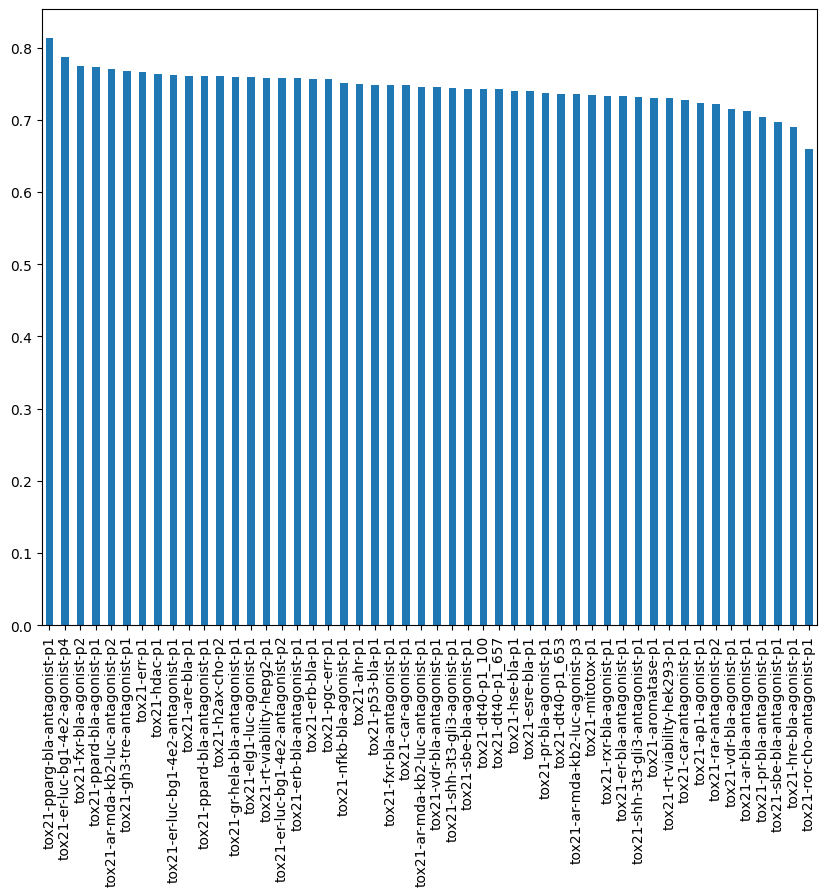

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = assay_per.mean_bal_acc.plot.bar()
ax.set_xticklabels(assay_per.Assay_name, rotation=90)